In [145]:
import numpy as np
from matplotlib import pyplot as plt
import re
import string
from sklearn.metrics import f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk import download
import smart_open
smart_open.open = smart_open.smart_open
import pandas as pd
import preprocessor as p
import gensim.models as gm
import time
import random
from pathlib import Path

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


import torch 
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

from torch.utils.data import DataLoader, Dataset

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence


download('stopwords')

[nltk_data] Downloading package stopwords to /home/mayank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [167]:

# To store the contents of a tweet in an efficient manner
class Data:
    def __init__(self):
        self.uid = None
        self.content = ''
        self.sentiment = ''

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        """
        Define the layers of the module.

        vocab_size - vocabulary size
        embedding_dim - size of the dense word vectors
        hidden_dim - size of the hidden states
        output_dim - number of classes
        n_layers - number of multi-layer RNN
        bidirectional - boolean - use both directions of LSTM
        dropout - dropout probability
        pad_idx -  string representing the pad token
        """
        
        super().__init__()

        # 1. Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                               hidden_dim, 
                               num_layers=n_layers,
                               bidirectional=bidirectional,
                               dropout=dropout)
        
        # 3. Fully-connected layer
        self.predictor = nn.Linear(hidden_dim * 2, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
      
        # 4. Softmax layer for probabilities
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text, text_lengths):
        """
        The forward method is called when data is fed into the model.

        text - [sentence length, batch size]
        text_lengths - lengths of sentences
        """

        # Embedding
        embedded = self.dropout(self.embedding(text))    

        # Pack the embeddings for variable-length sequences
        text_lengths = text_lengths.cpu()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # LSTM encoder
        packed_output, (hidden, cell) = self.encoder(packed_embedded)

        # Unpack sequences
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
 
        # Concatenate the final forward and backward hidden states and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        # Pass through the fully connected layer
        logits = self.predictor(hidden)  # [batch size, output_dim]

        # print(logits)
        # Apply softmax to get probabilities
        # probabilities = self.softmax(logits)  # [batch size, output_dim]
        # print(probabilities)
        # outputs = logits
        # max_probab, _ = torch.max(outputs,1)
        return logits


class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        """
        Define the layers of the module.

        vocab_size - vocabulary size
        embedding_dim - size of the dense word vectors
        hidden_dim - size of the hidden states
        output_dim - number of classes
        n_layers - number of multi-layer GRU
        bidirectional - boolean - use both directions of GRU
        dropout - dropout probability
        """

        super().__init__()

        # 1. Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. GRU layer
        self.encoder = nn.GRU(embedding_dim, 
                              hidden_dim, 
                              num_layers=n_layers,
                              bidirectional=bidirectional,
                              dropout=dropout)
        
        # 3. Fully-connected layer
        self.predictor = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """
        The forward method is called when data is fed into the model.

        text - [sentence length, batch size]
        text_lengths - lengths of sentences
        """

        # Embedding
        embedded = self.dropout(self.embedding(text))    

        # Pack the embeddings for variable-length sequences
        text_lengths = text_lengths.cpu()
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        # GRU encoder
        packed_output, hidden = self.encoder(packed_embedded)

        # Unpack sequences
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # Concatenate the final forward and backward hidden states (if bidirectional) and apply dropout
        if self.encoder.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        # Pass through the fully connected layer
        logits = self.predictor(hidden)  # [batch size, output_dim]

        return logits


class Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, n_heads, ff_dim):
        """
        Define the layers of the Transformer module.

        vocab_size - vocabulary size
        embedding_dim - size of the dense word vectors
        hidden_dim - size of the hidden states (for the output layer)
        output_dim - number of classes
        n_layers - number of transformer layers
        bidirectional - boolean - use both directions of transformer
        dropout - dropout probability
        n_heads - number of attention heads
        ff_dim - dimension of the feedforward network inside transformer
        """

        super().__init__()

        # 1. Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. Transformer layers
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim,
                                                                   nhead=n_heads,
                                                                   dim_feedforward=ff_dim,
                                                                   dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=n_layers)

        # 3. Fully-connected layer
        self.predictor = nn.Linear(embedding_dim, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """
        The forward method is called when data is fed into the model.

        text - [sentence length, batch size]
        text_lengths - lengths of sentences
        """

        # Embedding
        embedded = self.dropout(self.embedding(text))  # [sentence length, batch size, embedding_dim]

        # Make the input suitable for transformer (batch first format to seq_len first)
        embedded = embedded.permute(1, 0, 2)  # [batch size, sentence length, embedding_dim] -> [sentence length, batch size, embedding_dim]

        # Apply transformer
        transformer_output = self.transformer_encoder(embedded)

        # Use the last hidden state from the transformer (you could also use other pooling methods)
        final_hidden_state = transformer_output[-1, :, :]  # [batch size, embedding_dim]

        # Pass through the fully connected layer
        logits = self.predictor(final_hidden_state)  # [batch size, output_dim]

        return logits
    
import torch
import torch.nn as nn

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, kernel_sizes, dropout):
        """
        Define the layers of the CNN model.

        vocab_size - vocabulary size
        embedding_dim - size of the dense word vectors
        hidden_dim - size of the hidden states (not used in CNN)
        output_dim - number of classes
        kernel_sizes - list of kernel sizes for different convolutions
        dropout - dropout probability
        """

        super().__init__()

        # 1. Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=hidden_dim,
                      kernel_size=(k, embedding_dim)) 
            for k in kernel_sizes
        ])

        # 3. Fully-connected layer
        self.fc = nn.Linear(len(kernel_sizes) * hidden_dim, output_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """
        The forward method is called when data is fed into the model.

        text - [sentence length, batch size]
        text_lengths - lengths of sentences
        """

        # Embedding
        embedded = self.embedding(text)  # [sentence length, batch size, embedding_dim]
        embedded = embedded.unsqueeze(1)  # [sentence length, 1, batch size, embedding_dim]

        # Apply convolutions
        conved = [torch.relu(conv(embedded)).squeeze(3) for conv in self.convs]  # List of [sentence length, batch size, hidden_dim]
        
        # Max-pooling over each convolution
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]  # [batch size, hidden_dim]
        
        # Concatenate pooled features from each kernel
        cat = torch.cat(pooled, dim=1)  # [batch size, len(kernel_sizes) * hidden_dim]

        # Apply dropout
        cat = self.dropout(cat)

        # Fully connected layer
        logits = self.fc(cat)  # [batch size, output_dim]

        return logits



In [147]:
device = 'cuda'

In [148]:
# Function to clean (/pre process) a given tweet
def cleanTweet(data):
    # Doing various pre processing steps to clean the contents of the given tweet
    data.content = re.sub(r'\_', '', data.content) # remove underscores
    data.content = re.sub(r'…', '', data.content) # remove elipses/dots
    data.content = re.sub(r'\.', '', data.content) # remove elipses/dots
    data.content = re.sub(r'^RT[\s]+', '', data.content) # remove retweets
    data.content = re.sub("[#@©àâ€¦¥°¤ð¹ÿœ¾¨‡†§‹²¿¸ˆ]", '', data.content) # remove weird symbols
    data.content = data.content.split("http")[0].split('https')[0] # remove http/https
    data.content = ''.join([i for i in data.content if not i.isdigit()]) # remove digits
    data.content = ''.join([word for word in data.content if word not in string.punctuation]) # remove punctuations
    data.content = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True).tokenize(data.content)
    data.content = ' '.join([i for i in data.content]) # convert to string
    return data

# Loading the stopwords form both engish as well as hinglish
#Stop words English: is, and, has, the, etc.
#Hinglish Stop words: aise, abbey, kya, etc.
def load_stop_words():
    stopwords_english = stopwords.words('english')
    stopwords_hinglish = []
    with open('./stop_hinglish.txt','r') as fp:
        while True:
            line = fp.readline()
            if not line:
                break
            stopwords_hinglish.append(line.strip())
    return stopwords_english, stopwords_hinglish

#Function to read the given file and return the contents in the form of a list of Data objects
def readFile(filename, test_data=False):
    stemmer_english = PorterStemmer()
    stopwords_english, stopwords_hinglish = load_stop_words()
    all_datas = []
    with open(filename, 'r', encoding="utf8") as fp:
        data = Data()
        last_one = False
        while True:
            line = fp.readline()
            if not line:
                last_one = True
            if len(line.split()) > 1 or last_one==True:
                if last_one==True or line.split()[0] == 'meta':
                    if len(data.content) > 0 or last_one==True:
                        all_datas.append(cleanTweet(data))
                        if last_one==True:
                            break
                        data = Data()
                    data.uid = line.split()[1]
                    data.sentiment = line.split()[2] if test_data==False else None
                else:
                    if line.split()[1] == "Eng":
                        if line.split()[0] not in stopwords_english:
                            data.content += stemmer_english.stem(line.split()[0]) + " "
                    elif line.split()[1] == "Hin":
                        if line.split()[0] not in stopwords_hinglish:
                            data.content += line.split()[0] + " "
                    else:
                        data.content += line.split()[0] + " "
        return all_datas



In [149]:
all_tweets = readFile('Hinglish_train_14k_split_conll.txt')

# Remove emojies, reserved words and links
t=[]
labels=[]
label_map = {'negative':0, 'neutral':1, 'positive':2}


    
for i in range (len(all_tweets)) :
    if (all_tweets[i].content==""):
        # print(all_tweets[i].uid, "gap",all_tweets[i].content, "gap",all_tweets[i].sentiment)
        pass
    else:
        t.append(p.clean(all_tweets[i].content))
        labels.append(label_map[all_tweets[i].sentiment])
tweets_only_text=t

# print(tweets_only_text[0])  
# print(all_tweets[0].content)
# print(len(tweets_only_text))
t=[]

for i in range(len(tweets_only_text)):
    if re.search("http[.]*",tweets_only_text[i])!=None:
        t.append(tweets_only_text[i][:re.search("http[.]*",tweets_only_text[i]).span()[0]])
tweets=t

cleaned_tweets = []
tokenized_tweets = []
words  = []
for tweet in (tweets_only_text):
    for token in tweet.split():
        if token not in string.punctuation:
            words.append(token.lower())
    cleaned_tweets.append(" ".join(words))
    tokenized_tweets.append(words)
    words = []

# print(all_tweets[0].content)
# print(tweets_only_text[0])
# print(cleaned_tweets[0])
# print(tokenized_tweets[0])




print(f'Cleaned tweets length :- {len(cleaned_tweets)}')
output=labels[:len(cleaned_tweets)]
id = []
for i in range (len(cleaned_tweets)):
    id.append(i)
dict = {'id' :id, 'text':cleaned_tweets, "label":output}
df_tweets = pd.DataFrame(dict)
df_tweets.to_csv('train_data.csv', encoding='utf-8',index=False)
df_tweets = pd.read_csv('train_data.csv')
df_tweets.dropna()
df_tweets=df_tweets.drop(index=7192)
# df_tweets=df_tweets.drop(df_tweets[df_tweets['text']==''].index)
print(len(df_tweets))
#tweets_only_text=t
df_tweets.to_csv('train_data.csv', encoding='utf-8',index=False)

# print (df_tweets.head())


Cleaned tweets length :- 13989
13988


In [150]:
# Create word2vec embedding from the code-mixed tweets(tokenized form)
from gensim.models import Word2Vec
model_src = Word2Vec(sentences=tokenized_tweets, vector_size=25, window=5, min_count=1, workers=4)
model_src.wv.save_word2vec_format('mapped_src.model')

#Load target language embeddings
import gensim.downloader as api
model_trgt = api.load("glove-twitter-25")
model_trgt.save_word2vec_format('model_trgt.model')


In [151]:

TEXT = Field(lower=True, include_lengths= True)
LABEL = Field(sequential=False, use_vocab=False, dtype=torch.float)

# Map data to fields
fields = [('id',None), ('text', TEXT), ('label', LABEL) ]

# Apply field definition to create torch dataset
dataset = TabularDataset(
        path="train_data.csv",
        format="CSV",
        fields=fields,
        skip_header=True
        )


In [152]:
# Split data into train, test, validation sets22
(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))


# Vocabulary
TEXT.build_vocab(dataset)
TEXT.vocab.freqs.most_common(10)


BATCH_SIZE = 128


# sort_within_batch sorts all the tensors within a batch by their lengths
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

# print(vars(train_iterator.dataset[100]))



Number of train data: 11190
Number of test data: 1399
Number of validation data: 1399


In [153]:

# Matching the dimensions
# TEXT=TEXT[:-2]
print (len(TEXT.vocab))
# model_src = gm.KeyedVectors.load_word2vec_format('mapped_src.model')
model_src = gm.KeyedVectors.load_word2vec_format('model_trgt.model')
print (len(model_src))
model_src = torch.FloatTensor(model_src.vectors)
print(model_src.shape)


37195
1193514
torch.Size([1193514, 25])


In [154]:

# Load the cross-lingual embedding

# model_pretrained = gm.KeyedVectors.load_word2vec_format('mapped_src.model')
model_pretrained = gm.KeyedVectors.load_word2vec_format('model_trgt.model')


# # Filter TEXT.vocab to include only tokens present in Word2Vec
# pretrained_vocab = {word: idx for idx, word in enumerate(model_pretrained.key_to_index.keys())}
# filtered_vocab = {word: idx for word, idx in TEXT.vocab.stoi.items() if word in pretrained_vocab}

# filtered_vocab['<pad>'] = len(filtered_vocab)
# # Update TEXT.vocab to match the filtered vocabulary
# TEXT.vocab.stoi = filtered_vocab
# TEXT.vocab.itos = list(filtered_vocab.keys())

# print('TEXT VOCAB LENGTH',len(TEXT.vocab))



In [184]:
# Model Architecture

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 25
HIDDEN_DIM = 128
OUTPUT_DIM = 3
N_LAYERS = 8
BIDIRECTIONAL = True
DROPOUT = 0.2
# Get pad token index from vocab
# PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]


In [185]:
model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT)




In [175]:
model = GRU(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT)

In [138]:
model = Transformer(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT, 5, 125)

In [168]:
model = CNNTextClassifier(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            [3,5,7],
            DROPOUT)

In [186]:
# from transformers import BertTokenizer, BertModel
# from transformers import XLMRobertaTokenizer, XLMRobertaModel
# from sklearn.decomposition import TruncatedSVD

# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')
# model_x = XLMRobertaModel.from_pretrained('xlm-roberta-base')
# model_x = model_x.to(device)

# Load Multilingual BERT
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# model_b = BertModel.from_pretrained('bert-base-multilingual-cased')
# model_b = model_b.to(device)
# Initialize the embedding layer to the size of the TEXT vocab
embedding_matrix = torch.zeros(len(TEXT.vocab), EMBEDDING_DIM)

# Fill in the embedding matrix with pre-trained embeddings for known words
for word, idx in TEXT.vocab.stoi.items():
    if word in model_pretrained.key_to_index:  # Check if the word exists in pre-trained embeddings
        embedding_matrix[idx] = torch.tensor(model_pretrained[word])
    # Tokenize Hinglish text
    # inputs = tokenizer(word, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # inputs = {key: value.to(device) for key, value in inputs.items()}
    # outputs = model_x(**inputs)

    # Extract embeddings
    # embeddings = outputs.last_hidden_state[:, 0, :]
    # embeddings_cpu=embeddings.squeeze(0).detach().cpu().numpy().reshape(1, -1)
    # svd = TruncatedSVD(n_components=25, random_state=42)  # Reduce to 25 dimensions
    # reduced_embeddings = torch.tensor(svd.fit_transform(embeddings_cpu))#.clone().detach()

    # embedding_matrix[idx] = reduced_embeddings.squeeze(0)
    else:
        # Initialize unknown words (e.g., <unk>, <pad>) with random values or zeros
        embedding_matrix[idx] = torch.ones(EMBEDDING_DIM)

# Replace the embedding layer weights with the new matrix
# model.embedding = nn.Embedding(len(TEXT.vocab), EMBEDDING_DIM)
model.embedding.weight.data.copy_(embedding_matrix)
# model.embedding.padding_idx = TEXT.vocab.stoi['<pad>']
'''
pretrained_embeddings = torch.FloatTensor(model_pretrained.vectors)
print(pretrained_embeddings.shape)

# Replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)
# Initialize model embeddings with pretrained embeddings
# model.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
'''


'\npretrained_embeddings = torch.FloatTensor(model_pretrained.vectors)\nprint(pretrained_embeddings.shape)\n\n# Replace the initial weights of the embedding layer with the pre-trained embeddings\nmodel.embedding.weight.data.copy_(pretrained_embeddings)\n# Initialize model embeddings with pretrained embeddings\n# model.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)\n'

In [187]:
# Adam optimizer used to update the weights
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=5e-4)



In [188]:
# Loss function: binary cross entropy with logits
# It restricts the predictions to a number between 0 and 1 using the logit function
# then use the bound scarlar to calculate the loss using binary cross entropy
# criterion = nn.BCEWithLogitsLoss()
criterion=nn.CrossEntropyLoss()


In [189]:
# Use GPU
model = model.to(device)
criterion = criterion.to(device)


In [190]:
# Helper functions

def batch_accuracy(predictions, label):
    """
    Returns accuracy per batch.

    predictions - float
    label - 0 or 1
    """

    # Round predictions to the closest integer using the sigmoid function
    preds_sig = torch.softmax(predictions, dim=1)
    # print(preds_sig.shape)
    preds=torch.argmax(preds_sig, dim=1)
    
    # If prediction is equal to label
    correct = (preds == label).float()
    # Average correct predictions
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):
    """
    Returns the minutes and seconds.
    """

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

def train(model, iterator, optimizer, criterion):
    """
    Function to evaluate training loss and accuracy.

    iterator - train iterator
    """
    
    # Cumulated Training loss
    training_loss = 0.0
    # Cumulated Training accuracy
    training_acc = 0.0
    
    # Set model to training mode
    model.train()
    
    # For each batch in the training iterator
    for batch in iterator:
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # batch.text is a tuple (tensor, len of seq)
        text, text_lengths = batch.text
       
        # 2. Compute the predictions
        # text_lengths[text_lengths==0]=1
        # print(text, text_lengths)
        predictions = model(text, text_lengths)
        # print(predictions)
        predictions=predictions.squeeze(1)
        # predictions=predictions.float()
        # print(predictions)
        # print(batch.label)
        # print("Predictions shape:", predictions.shape)
        # print("Batch label shape:", batch.label.shape)  
        # 3. Compute loss
        loss = criterion(predictions, batch.label.long())
        
        # Compute accuracy
        accuracy = batch_accuracy(predictions, batch.label)
        
        # 4. Use loss to compute gradients
        loss.backward()
        
        # 5. Use optimizer to take gradient step
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()
    
    return training_loss / len(iterator), training_acc / len(iterator)

def evaluate(model, iterator, criterion):
    """
    Function to evaluate the loss and accuracy of validation and test sets.

    iterator - validation or test iterator
    """
    
    # Cumulated Training loss
    eval_loss = 0.0
    # Cumulated Training accuracy
    eval_acc = 0
    
    # Set model to evaluation mode
    model.eval()
    
    # Don't calculate the gradients
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label.long())
            outputs = predictions
            # print(outputs)
            # _, predictions = torch.max(outputs,1)
            
            accuracy = batch_accuracy(predictions, batch.label)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)


Epoch 1:
	 Total Time: 0m 2s
	 Train Loss 1.1 | Train Accuracy: 36.99%
	 Validation Loss 1.09 | Validation Accuracy: 37.58%
Epoch 2:
	 Total Time: 0m 2s
	 Train Loss 1.06 | Train Accuracy: 41.99%
	 Validation Loss 1.03 | Validation Accuracy: 47.15%
Epoch 3:
	 Total Time: 0m 2s
	 Train Loss 1.02 | Train Accuracy: 46.05%
	 Validation Loss 1.0 | Validation Accuracy: 48.96%
Epoch 4:
	 Total Time: 0m 2s
	 Train Loss 0.99 | Train Accuracy: 47.84%
	 Validation Loss 0.97 | Validation Accuracy: 51.31%
Epoch 5:
	 Total Time: 0m 2s
	 Train Loss 0.98 | Train Accuracy: 48.83%
	 Validation Loss 0.97 | Validation Accuracy: 51.92%
Epoch 6:
	 Total Time: 0m 2s
	 Train Loss 0.97 | Train Accuracy: 49.9%
	 Validation Loss 0.96 | Validation Accuracy: 52.27%
Epoch 7:
	 Total Time: 0m 2s
	 Train Loss 0.96 | Train Accuracy: 50.66%
	 Validation Loss 0.96 | Validation Accuracy: 51.55%
Epoch 8:
	 Total Time: 0m 2s
	 Train Loss 0.96 | Train Accuracy: 50.5%
	 Validation Loss 0.96 | Validation Accuracy: 51.7%
Epoch

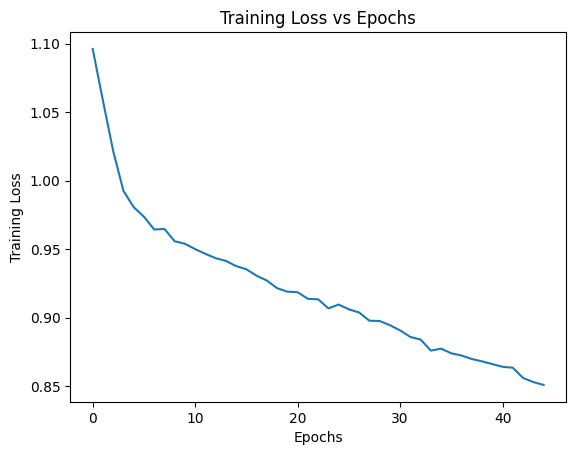

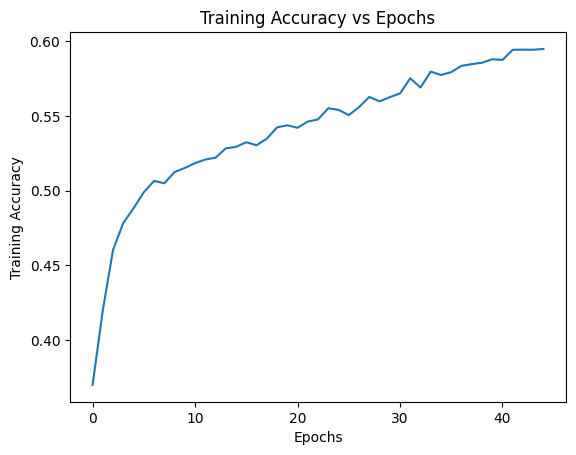

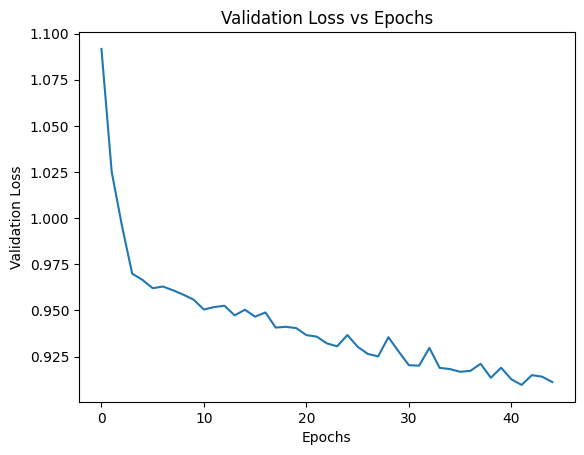

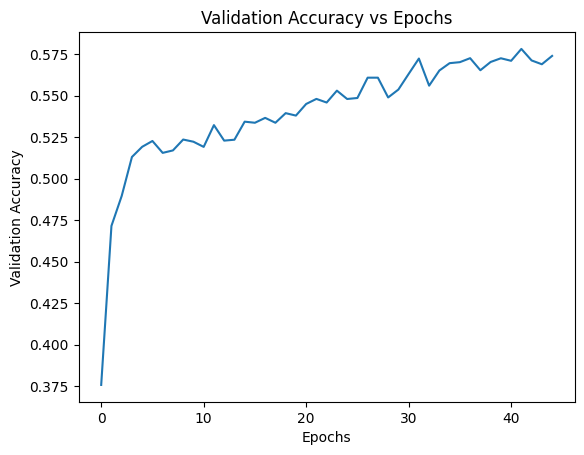

In [191]:
# Number of epochs
NUM_EPOCHS = 45

# Lowest validation loss
best_valid_loss = float('inf')
train_losses=[]
train_accs=[]
val_losses=[]
val_accs=[]
for epoch in range(NUM_EPOCHS):

    start_time = time.time()
  
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion) # Evaluate training loss and accuracy
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion) # Evaluate validation loss and accuracy
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)
    
    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    # At each epoch, if the validation loss is the best
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        
        torch.save(model.state_dict(), 'model-small.pt') # Save the parameters of the model

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))



plt.plot(train_losses)
plt.title("Training Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()
plt.savefig("train_loss.png")
plt.close()

plt.plot(train_accs)
plt.title("Training Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.show()
plt.savefig("train_acc.png")
plt.close()

plt.plot(val_losses)
plt.title("Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.show()
plt.savefig("val_loss.png")
plt.close()

plt.plot(val_accs)
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.show()
plt.savefig("val_acc.png")
plt.close()


In [192]:
import itertools

def plot_confusion_matrix(cm,title='Confusion Matrix',cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    classes = ['neutral','positive','negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_results(y_test, y_pred):
    print("F1 Score: ", f1_score(y_test, y_pred, average="weighted"))
    print()
    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    plot_confusion_matrix(cnf_matrix)


In [193]:

# pred = model.predict(Xt)
def test(model, iterator):
    import torch
    
    # Set model to evaluation mode
    model.eval()
    
    # Don't calculate the gradients
    all_predictions = []
    all_tags = []

    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            tags = batch.label  # Assuming the original tags are in `batch.tag`
            
            predictions = model(text, text_lengths).squeeze(1)
            # Round predictions to the closest integer using the sigmoid function
            preds_sig = torch.softmax(predictions, dim=1)
            # print(preds_sig.shape)
            predictions=torch.argmax(preds_sig, dim=1)
    
            # Store the predictions and tags
            all_predictions.extend(predictions.cpu().numpy())  # Convert to numpy and append
            all_tags.extend(tags.cpu().numpy())  # Convert to numpy and append

    return all_tags, all_predictions



F1 Score:  0.5646864512766558



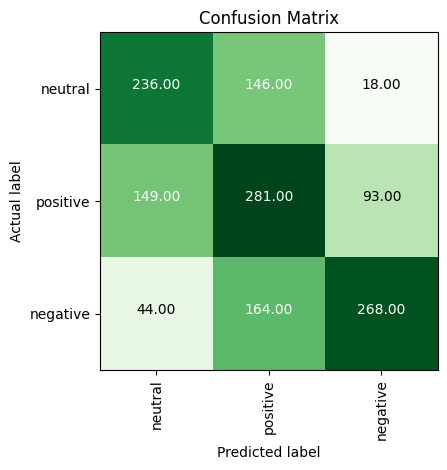

In [194]:
x,y=test(model, test_iterator)
show_results(x,y)

In [ ]:
x

In [ ]:
y